In [1]:
# Initialization: Load shared functions and simulated data 

# Load shared functions
!curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py
%run shared_functions.py

# Get simulated data from Github repository
if not os.path.exists("simulated-data-transformed"):
    !git clone https://github.com/ASIF-ISI-KOLKATA/Fraud_Transaction_Detection/blob/main/Baseline_Feature_Transformation.ipynb
        

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 31568  100 31568    0     0  54900      0 --:--:-- --:--:-- --:--:-- 54900


In [2]:
#Model selection: Decision trees

In [3]:
# Load data from the 2018-06-11 to the 2018-09-14

DIR_INPUT='simulated-data-transformed/data/' 

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

Load  files
Wall time: 8.98 s
937138 transactions loaded, containing 8139 fraudulent transactions


In [4]:
#The reference starting date for training is set at 2018-07-25, and the deltas to seven days
# Number of folds for the prequential validation
n_folds=4

# Set the starting day for the training period, and the deltas
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train=delta_delay=delta_test=delta_valid=delta_assessment=7

start_date_training_for_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))
start_date_training_for_test = start_date_training+datetime.timedelta(days=(n_folds-1)*delta_test)

In [5]:
#The performance metrics are the AUC ROC, the average Precision, and the Card Precision@100
# Only keep columns that are needed as argument to custome scoring function
# to reduce serialisation time of transaction dataset
transactions_df_scorer=transactions_df[['CUSTOMER_ID', 'TX_FRAUD','TX_TIME_DAYS']]

card_precision_top_100 = sklearn.metrics.make_scorer(card_precision_top_k_custom, 
                                                     needs_proba=True, 
                                                     top_k=100, 
                                                     transactions_df=transactions_df_scorer)

performance_metrics_list_grid=['roc_auc', 'average_precision', 'card_precision@100']
performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100']

scoring = {'roc_auc':'roc_auc',
           'average_precision': 'average_precision',
           'card_precision@100': card_precision_top_100,
           }

In [6]:
#For the sake of conciseness, let us define a model_selection_wrapper function, that will perform prequential validation for both the validation and the test sets
def model_selection_wrapper(transactions_df, 
                            classifier, 
                            input_features, output_feature,
                            parameters, 
                            scoring, 
                            start_date_training_for_valid,
                            start_date_training_for_test,
                            n_folds=4,
                            delta_train=7, 
                            delta_delay=7, 
                            delta_assessment=7,
                            performance_metrics_list_grid=['roc_auc'],
                            performance_metrics_list=['AUC ROC'],
                            n_jobs=-1):

    # Get performances on the validation set using prequential validation
    performances_df_validation=prequential_grid_search(transactions_df, classifier, 
                            input_features, output_feature,
                            parameters, scoring, 
                            start_date_training=start_date_training_for_valid,
                            n_folds=n_folds,
                            expe_type='Validation',
                            delta_train=delta_train, 
                            delta_delay=delta_delay, 
                            delta_assessment=delta_assessment,
                            performance_metrics_list_grid=performance_metrics_list_grid,
                            performance_metrics_list=performance_metrics_list,
                            n_jobs=n_jobs)
    
    # Get performances on the test set using prequential validation
    performances_df_test=prequential_grid_search(transactions_df, classifier, 
                            input_features, output_feature,
                            parameters, scoring, 
                            start_date_training=start_date_training_for_test,
                            n_folds=n_folds,
                            expe_type='Test',
                            delta_train=delta_train, 
                            delta_delay=delta_delay, 
                            delta_assessment=delta_assessment,
                            performance_metrics_list_grid=performance_metrics_list_grid,
                            performance_metrics_list=performance_metrics_list,
                            n_jobs=n_jobs)
    
    # Bind the two resulting DataFrames
    performances_df_validation.drop(columns=['Parameters','Execution time'], inplace=True)
    performances_df=pd.concat([performances_df_test,performances_df_validation],axis=1)

    # And return as a single DataFrame
    return performances_df

In [7]:
#The implementation using decision trees as predictions models, for maximum depth in [2,3,4,5,6,7,8,9,10,20,50], is obtained with
# Define classifier
classifier = sklearn.tree.DecisionTreeClassifier()

# Set of parameters for which to assess model performances
parameters = {'clf__max_depth':[2,3,4,5,6,7,8,9,10,20,50], 'clf__random_state':[0]}

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_dt = time.time()-start_time

# Select parameter of interest (max_depth)
parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__max_depth'] for i in range(len(parameters_dict))]

# Rename to performances_df_dt for model performance comparison at the end of this notebook
performances_df_dt=performances_df

In [8]:
performances_df_dt

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.803231,0.016668,0.551173,0.050648,0.270000,0.022655,"{'clf__max_depth': 2, 'clf__random_state': 0}",0.716886,0.794608,0.018808,0.515490,0.060289,0.260714,0.020417,2
1,0.820671,0.017545,0.612959,0.043241,0.284643,0.023504,"{'clf__max_depth': 3, 'clf__random_state': 0}",0.795544,0.807881,0.014856,0.576470,0.027778,0.274286,0.022062,3
2,0.816527,0.019515,0.606828,0.054507,0.282500,0.023763,"{'clf__max_depth': 4, 'clf__random_state': 0}",0.880244,0.811839,0.013812,0.592603,0.018036,0.276429,0.019911,4
3,0.801922,0.021198,0.594158,0.039054,0.278214,0.017035,"{'clf__max_depth': 5, 'clf__random_state': 0}",1.031182,0.804012,0.006447,0.580668,0.016454,0.271786,0.016456,5
4,0.793539,0.027146,0.580718,0.039895,0.272500,0.014156,"{'clf__max_depth': 6, 'clf__random_state': 0}",1.009621,0.791430,0.012864,0.567061,0.022308,0.271429,0.015085,6
5,0.784903,0.017319,0.556300,0.034498,0.268929,0.014476,"{'clf__max_depth': 7, 'clf__random_state': 0}",1.088560,0.787812,0.026211,0.552354,0.030428,0.268214,0.017005,7
6,0.787678,0.022349,0.559010,0.036890,0.270000,0.015452,"{'clf__max_depth': 8, 'clf__random_state': 0}",1.241284,0.768977,0.018690,0.538803,0.027076,0.258571,0.017814,8
7,0.784610,0.017041,0.556295,0.030344,0.271429,0.016506,"{'clf__max_depth': 9, 'clf__random_state': 0}",1.240410,0.758872,0.013057,0.508977,0.026373,0.253214,0.017623,9
8,0.773300,0.018946,0.553997,0.034290,0.266429,0.017971,"{'clf__max_depth': 10, 'clf__random_state': 0}",1.310816,0.764171,0.015684,0.520826,0.015443,0.260357,0.010708,10
9,0.797305,0.017065,0.478287,0.021112,0.271429,0.017350,"{'clf__max_depth': 20, 'clf__random_state': 0}",2.011626,0.781357,0.015683,0.459739,0.023474,0.260357,0.017094,20


In [9]:
def get_summary_performances(performances_df, parameter_column_name="Parameters summary"):

    # Three performance metrics
    metrics = ['AUC ROC','Average precision','Card Precision@100']
    performances_results=pd.DataFrame(columns=metrics)
    
    # Reset indices in case a subset of a performane DataFrame is provided as input
    performances_df.reset_index(drop=True,inplace=True)

    # Lists of parameters/performances that will be retrieved for the best estimated parameters
    best_estimated_parameters = []
    validation_performance = []
    test_performance = []
    
    # For each performance metric, get the validation and test performance for the best estimated parameter
    for metric in metrics:
    
        # Find the index which provides the best validation performance
        index_best_validation_performance = performances_df.index[np.argmax(performances_df[metric+' Validation'].values)]
    
        # Retrieve the corresponding parameters
        best_estimated_parameters.append(performances_df[parameter_column_name].iloc[index_best_validation_performance])
        
        # Add validation performance to the validation_performance list (mean+/-std)
        validation_performance.append(
                str(round(performances_df[metric+' Validation'].iloc[index_best_validation_performance],3))+
                '+/-'+
                str(round(performances_df[metric+' Validation'+' Std'].iloc[index_best_validation_performance],2))
        )
        
        # Add test performance to the test_performance list (mean+/-std)
        test_performance.append(
                str(round(performances_df[metric+' Test'].iloc[index_best_validation_performance],3))+
                '+/-'+
                str(round(performances_df[metric+' Test'+' Std'].iloc[index_best_validation_performance],2))
        )
    
    # Add results to the performances_results DataFrame
    performances_results.loc["Best estimated parameters"]=best_estimated_parameters
    performances_results.loc["Validation performance"]=validation_performance
    performances_results.loc["Test performance"]=test_performance

    # Lists of parameters/performances that will be retrieved for the optimal parameters
    optimal_test_performance = []
    optimal_parameters = []

    # For each performance metric, get the performance for the optimal parameter
    for metric in ['AUC ROC Test','Average precision Test','Card Precision@100 Test']:
    
        # Find the index which provides the optimal performance
        index_optimal_test_performance = performances_df.index[np.argmax(performances_df[metric].values)]
    
        # Retrieve the corresponding parameters
        optimal_parameters.append(performances_df[parameter_column_name].iloc[index_optimal_test_performance])
    
        # Add test performance to the test_performance list (mean+/-std)
        optimal_test_performance.append(
                str(round(performances_df[metric].iloc[index_optimal_test_performance],3))+
                '+/-'+
                str(round(performances_df[metric+' Std'].iloc[index_optimal_test_performance],2))
        )

    # Add results to the performances_results DataFrame
    performances_results.loc["Optimal parameters"]=optimal_parameters
    performances_results.loc["Optimal test performance"]=optimal_test_performance
    
    return performances_results

In [10]:
summary_performances_dt=get_summary_performances(performances_df_dt, parameter_column_name="Parameters summary")
summary_performances_dt

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,4,4,4
Validation performance,0.812+/-0.01,0.593+/-0.02,0.276+/-0.02
Test performance,0.817+/-0.02,0.607+/-0.05,0.283+/-0.02
Optimal parameters,3,3,3
Optimal test performance,0.821+/-0.02,0.613+/-0.04,0.285+/-0.02


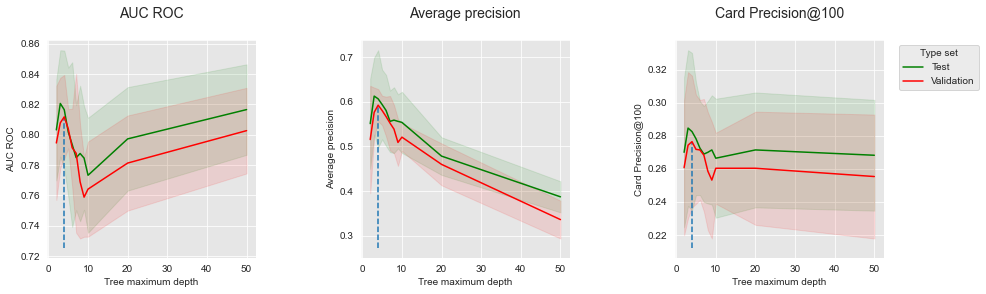

In [11]:
get_performances_plots(performances_df_dt, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       summary_performances=summary_performances_dt)

In [12]:
#Model selection: Exploration of other model classes

In [13]:
#Logistic regression
classifier = sklearn.linear_model.LogisticRegression()

parameters = {'clf__C':[0.1,1,10,100], 'clf__random_state':[0]}

start_time=time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_lr = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__C'] for i in range(len(parameters_dict))]

# Rename to performances_df_lr for model performance comparison at the end of this notebook
performances_df_lr=performances_df

In [14]:
performances_df_lr

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.873509,0.021225,0.646664,0.046432,0.294286,0.017957,"{'clf__C': 0.1, 'clf__random_state': 0}",0.993028,0.883329,0.012709,0.612668,0.036846,0.285000,0.022891,0.1
1,0.874037,0.020402,0.648346,0.045741,0.294286,0.017409,"{'clf__C': 1, 'clf__random_state': 0}",0.973242,0.884096,0.013900,0.615312,0.039238,0.283929,0.022528,1.0
2,0.874033,0.020326,0.648455,0.045515,0.293929,0.017939,"{'clf__C': 10, 'clf__random_state': 0}",1.272330,0.884120,0.013988,0.615403,0.039618,0.283929,0.022528,10.0
3,0.874033,0.020318,0.648437,0.045524,0.293929,0.017939,"{'clf__C': 100, 'clf__random_state': 0}",1.475600,0.884124,0.013997,0.615408,0.039622,0.283929,0.022528,100.0


In [15]:
summary_performances_lr=get_summary_performances(performances_df_lr, parameter_column_name="Parameters summary")
summary_performances_lr

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,100.0,100.0,0.1
Validation performance,0.884+/-0.01,0.615+/-0.04,0.285+/-0.02
Test performance,0.874+/-0.02,0.648+/-0.05,0.294+/-0.02
Optimal parameters,1.0,10.0,0.1
Optimal test performance,0.874+/-0.02,0.648+/-0.05,0.294+/-0.02


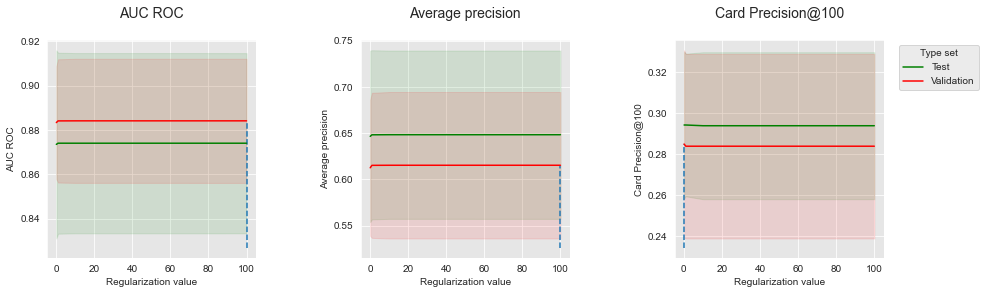

In [16]:
#Let us plot the performances as a function of the regularization value, together with the value that provides the best estimated performances
get_performances_plots(performances_df_lr, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Regularization value",
                       summary_performances=summary_performances_lr)

In [21]:
#Random forest
classifier = sklearn.ensemble.RandomForestClassifier()

# Note: n_jobs set to one for getting true execution times
parameters = {'clf__max_depth':[5,10,20,50], 'clf__n_estimators':[25,50,100],
              'clf__random_state':[0],'clf__n_jobs':[1]}

start_time=time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_rf = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['clf__n_estimators'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__max_depth'])
                                   for i in range(len(parameters_dict))]

# Rename to performances_df_rf for model performance comparison at the end of this notebook
performances_df_rf=performances_df

In [22]:
performances_df_rf

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.844256,0.019935,0.638414,0.039635,0.290714,0.022644,"{'clf__max_depth': 5, 'clf__n_estimators': 25,...",2.061592,0.840258,0.009221,0.621582,0.018705,0.284286,0.017900,25/5
1,0.853883,0.024165,0.639735,0.040995,0.291786,0.022619,"{'clf__max_depth': 5, 'clf__n_estimators': 50,...",3.719994,0.847994,0.008983,0.622896,0.020654,0.284286,0.017900,50/5
2,0.852986,0.022424,0.643732,0.039090,0.290714,0.022349,"{'clf__max_depth': 5, 'clf__n_estimators': 100...",6.801574,0.851257,0.008065,0.627699,0.019886,0.284643,0.019043,100/5
3,0.857536,0.019043,0.670292,0.041242,0.296786,0.019830,"{'clf__max_depth': 10, 'clf__n_estimators': 25...",3.366745,0.857188,0.016010,0.651893,0.018330,0.286786,0.018719,25/10
4,0.865405,0.015285,0.677113,0.036914,0.299643,0.020238,"{'clf__max_depth': 10, 'clf__n_estimators': 50...",6.209204,0.866516,0.015830,0.657237,0.021028,0.291429,0.020127,50/10
5,0.868341,0.012186,0.680444,0.035695,0.299643,0.020238,"{'clf__max_depth': 10, 'clf__n_estimators': 10...",11.791038,0.870893,0.014346,0.660862,0.021155,0.290000,0.020479,100/10
6,0.862845,0.011691,0.693040,0.038176,0.297857,0.020466,"{'clf__max_depth': 20, 'clf__n_estimators': 25...",5.086378,0.856465,0.016329,0.669831,0.022594,0.290714,0.019180,25/20
7,0.870907,0.008442,0.701202,0.037506,0.300000,0.020874,"{'clf__max_depth': 20, 'clf__n_estimators': 50...",9.614291,0.868799,0.019316,0.679112,0.021391,0.290000,0.020653,50/20
8,0.875294,0.012600,0.704783,0.035799,0.299643,0.019779,"{'clf__max_depth': 20, 'clf__n_estimators': 10...",18.556959,0.876727,0.019061,0.684994,0.025066,0.290714,0.018992,100/20
9,0.864942,0.014592,0.682929,0.041921,0.298571,0.023013,"{'clf__max_depth': 50, 'clf__n_estimators': 25...",5.457026,0.865558,0.016508,0.666047,0.022445,0.287857,0.018084,25/50


In [23]:
summary_performances_rf=get_summary_performances(performances_df_rf, parameter_column_name="Parameters summary")
summary_performances_rf

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,100/50,100/20,50/10
Validation performance,0.879+/-0.02,0.685+/-0.03,0.291+/-0.02
Test performance,0.876+/-0.01,0.705+/-0.04,0.3+/-0.02
Optimal parameters,100/50,100/20,50/50
Optimal test performance,0.876+/-0.01,0.705+/-0.04,0.301+/-0.02


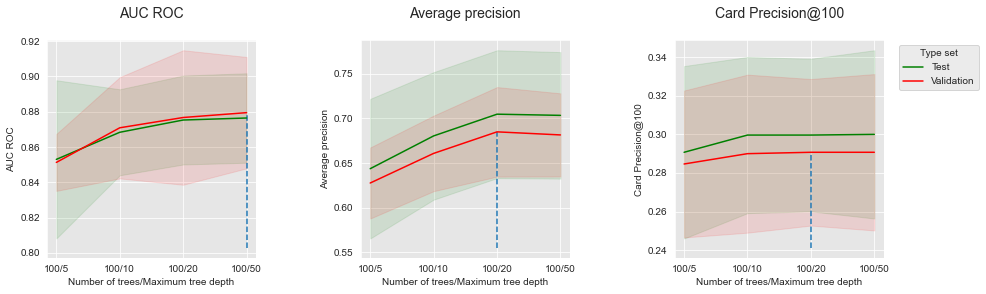

In [24]:
#Fixing the number of trees to 100, we get
performances_df_rf_fixed_number_of_trees=performances_df_rf[performances_df_rf["Parameters summary"].str.startswith("100")]

summary_performances_fixed_number_of_trees=get_summary_performances(performances_df_rf_fixed_number_of_trees, parameter_column_name="Parameters summary")

get_performances_plots(performances_df_rf_fixed_number_of_trees, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Number of trees/Maximum tree depth",
                       summary_performances=summary_performances_fixed_number_of_trees)

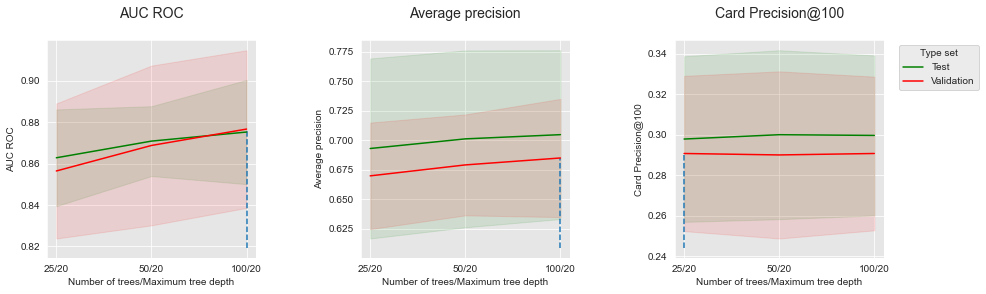

In [25]:
#Let us then fix the maximum tree depth, and the vary the number of estimators. Fixing the maximum tree depth to 20, we get
performances_df_rf_fixed_max_tree_depth=performances_df_rf[performances_df_rf["Parameters summary"].str.endswith("20")]

summary_performances_fixed_max_tree_depth=get_summary_performances(performances_df_rf_fixed_max_tree_depth, parameter_column_name="Parameters summary")

get_performances_plots(performances_df_rf_fixed_max_tree_depth, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Number of trees/Maximum tree depth",
                       summary_performances=summary_performances_fixed_max_tree_depth)

In [26]:
# Get the performance plot for a single performance metric
def get_execution_times_plot(performances_df,
                             title="",
                             parameter_name="Tree maximum depth"):
    
    fig, ax = plt.subplots(1,1, figsize=(5,4))
    
    # Plot data on graph
    ax.plot(performances_df['Parameters summary'], performances_df["Execution time"], 
            color="black")
        
    # Set title, and x and y axes labels
    ax.set_title(title, fontsize=14)
    ax.set(xlabel = parameter_name, ylabel="Execution time (seconds)")

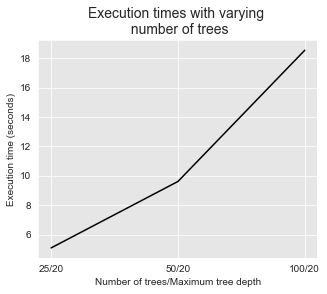

In [27]:
get_execution_times_plot(performances_df_rf_fixed_max_tree_depth, 
                         title="Execution times with varying \n number of trees",
                         parameter_name="Number of trees/Maximum tree depth")

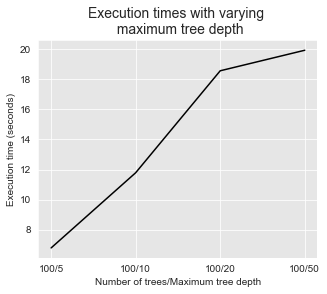

In [28]:
get_execution_times_plot(performances_df_rf_fixed_number_of_trees, 
                         title="Execution times with varying \n maximum tree depth",
                         parameter_name="Number of trees/Maximum tree depth")

In [29]:
print("Total execution time for the model selection procedure: "+str(round(execution_time_rf,2))+"s")

Total execution time for the model selection procedure: 937.31s


In [30]:
#XGBoost
classifier = xgboost.XGBClassifier()

parameters = {'clf__max_depth':[2,3,5], 'clf__n_estimators':[25,50,100], 'clf__learning_rate':[0.05, 0.1],
              'clf__random_state':[0], 'clf__n_jobs':[1], 'clf__verbosity':[0]}

start_time=time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_boosting = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['clf__n_estimators'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__learning_rate'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__max_depth'])
                                   for i in range(len(parameters_dict))]

# Rename to performances_df_xgboost for model performance comparison at the end of this notebook
performances_df_xgboost=performances_df

In [31]:
performances_df_xgboost

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.811234,0.019280,0.603811,0.040755,0.275714,0.021309,"{'clf__learning_rate': 0.05, 'clf__max_depth':...",2.229487,0.804765,0.012008,0.588426,0.027669,0.270714,0.019339,25/0.05/2
1,0.833026,0.021529,0.638276,0.041124,0.292857,0.021093,"{'clf__learning_rate': 0.05, 'clf__max_depth':...",3.746945,0.824865,0.007403,0.620503,0.018740,0.285714,0.021213,50/0.05/2
2,0.850487,0.017482,0.658778,0.043274,0.292857,0.021993,"{'clf__learning_rate': 0.05, 'clf__max_depth':...",6.773877,0.845037,0.013504,0.641901,0.018981,0.285714,0.018378,100/0.05/2
3,0.827839,0.018734,0.630738,0.037541,0.290000,0.021547,"{'clf__learning_rate': 0.05, 'clf__max_depth':...",2.857233,0.823165,0.010845,0.618076,0.019830,0.283929,0.020060,25/0.05/3
4,0.836631,0.022184,0.646748,0.038027,0.293571,0.020813,"{'clf__learning_rate': 0.05, 'clf__max_depth':...",4.963549,0.832725,0.012021,0.634398,0.023909,0.288214,0.019362,50/0.05/3
5,0.855558,0.018664,0.676701,0.046843,0.297857,0.020665,"{'clf__learning_rate': 0.05, 'clf__max_depth':...",9.393437,0.857147,0.016288,0.659119,0.027398,0.291429,0.020479,100/0.05/3
6,0.838170,0.022672,0.644167,0.036922,0.292143,0.022734,"{'clf__learning_rate': 0.05, 'clf__max_depth':...",4.139737,0.825694,0.012097,0.629998,0.020038,0.284643,0.020785,25/0.05/5
7,0.845095,0.022888,0.664565,0.048586,0.297500,0.022910,"{'clf__learning_rate': 0.05, 'clf__max_depth':...",7.602500,0.839410,0.019583,0.642649,0.026164,0.287143,0.021405,50/0.05/5
8,0.867666,0.008072,0.698068,0.032792,0.302857,0.017642,"{'clf__learning_rate': 0.05, 'clf__max_depth':...",14.770920,0.872706,0.014283,0.674565,0.028685,0.290000,0.019614,100/0.05/5
9,0.833057,0.021551,0.638215,0.041323,0.292857,0.021452,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",2.216676,0.824871,0.007406,0.620532,0.018880,0.286071,0.021102,25/0.1/2


In [32]:
summary_performances_xgboost=get_summary_performances(performances_df_xgboost, parameter_column_name="Parameters summary")
summary_performances_xgboost

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,100/0.1/3,100/0.1/3,100/0.1/3
Validation performance,0.886+/-0.01,0.692+/-0.03,0.295+/-0.02
Test performance,0.875+/-0.01,0.71+/-0.03,0.305+/-0.02
Optimal parameters,100/0.1/3,100/0.1/3,100/0.1/3
Optimal test performance,0.875+/-0.01,0.71+/-0.03,0.305+/-0.02


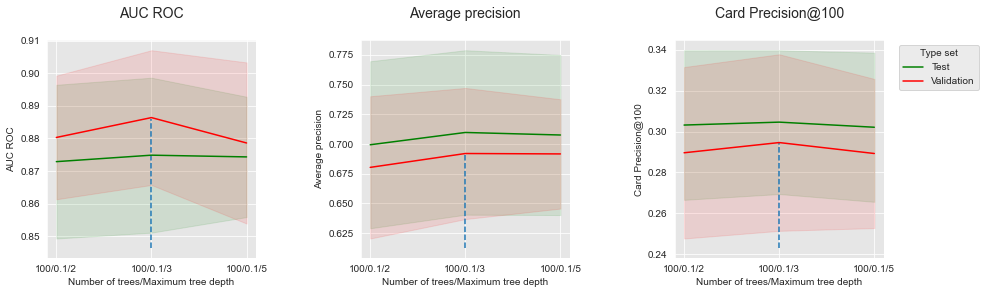

In [33]:
#Let us plot the performances as a function of the maximum tree depth, for a number of trees set to 100. Increasing the maximum tree depth does not clearly affect the performances. It slightly increases performances for AUC ROC and AP, but slightly decreases it for CP@100
performances_df_xgboost_fixed_number_of_trees=performances_df_xgboost[performances_df_xgboost["Parameters summary"].str.startswith("100/0.1")]

summary_performances_fixed_number_of_trees=get_summary_performances(performances_df_xgboost_fixed_number_of_trees, parameter_column_name="Parameters summary")

get_performances_plots(performances_df_xgboost_fixed_number_of_trees, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Number of trees/Maximum tree depth",
                       summary_performances=summary_performances_fixed_number_of_trees)

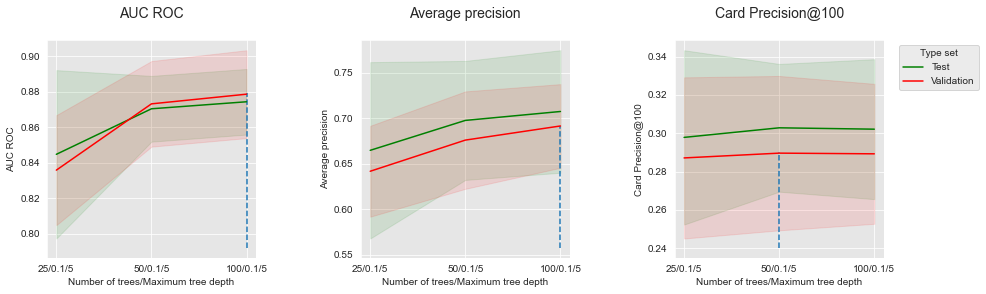

In [34]:
#Let us then plot the performances as a function of the number of trees, for a maximum tree depth set to 5
performances_df_xgboost_fixed_max_tree_depth=performances_df_xgboost[performances_df_xgboost["Parameters summary"].str.endswith("0.1/5")]

summary_performances_fixed_max_tree_depth=get_summary_performances(performances_df_xgboost_fixed_max_tree_depth, parameter_column_name="Parameters summary")

get_performances_plots(performances_df_xgboost_fixed_max_tree_depth, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Number of trees/Maximum tree depth",
                       summary_performances=summary_performances_fixed_max_tree_depth)

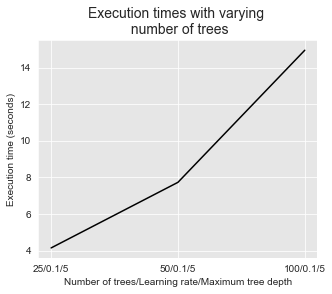

In [35]:
get_execution_times_plot(performances_df_xgboost_fixed_max_tree_depth, 
                         title="Execution times with varying \n number of trees",
                         parameter_name="Number of trees/Learning rate/Maximum tree depth")

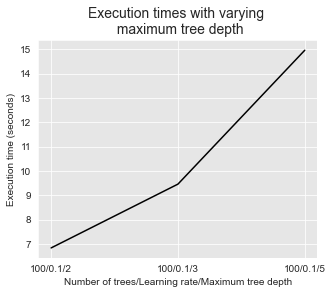

In [36]:
get_execution_times_plot(performances_df_xgboost_fixed_number_of_trees, 
                         title="Execution times with varying \n maximum tree depth",
                         parameter_name="Number of trees/Learning rate/Maximum tree depth")

In [37]:
print("Total execution time for the model selection procedure: "+str(round(execution_time_boosting,2))+"s")

Total execution time for the model selection procedure: 949.51s


In [38]:
#Comparison of model performances

In [39]:
performances_df_dictionary={
    "Decision Tree": performances_df_dt,
    "Logstic Regression": performances_df_lr,
    "Random Forest": performances_df_rf,
    "XGBoost": performances_df_xgboost
}

In [40]:
def model_selection_performances(performances_df_dictionary,
                                 performance_metric='AUC ROC'):
    
    # Note: max_depth of 50 is similar to None
    default_parameters_dictionary={
        "Decision Tree": 50,
        "Logstic Regression": 1,
        "Random Forest": "100/50",
        "XGBoost": "100/0.1/2"
    }
    
    mean_performances_dictionary={
        "Default parameters": [],
        "Best validation parameters": [],
        "Optimal parameters": []
    }
    
    std_performances_dictionary={
        "Default parameters": [],
        "Best validation parameters": [],
        "Optimal parameters": []
    }
    
    # For each model class
    for model_class, performances_df in performances_df_dictionary.items():
        
        # Get the performances for the default paramaters
        default_performances=performances_df[performances_df['Parameters summary']==default_parameters_dictionary[model_class]]
        default_performances=default_performances.round(decimals=3)
        
        mean_performances_dictionary["Default parameters"].append(default_performances[performance_metric+" Test"].values[0])
        std_performances_dictionary["Default parameters"].append(default_performances[performance_metric+" Test Std"].values[0])
        
        # Get the performances for the best estimated parameters
        performances_summary=get_summary_performances(performances_df, parameter_column_name="Parameters summary")
        mean_std_performances=performances_summary.loc[["Test performance"]][performance_metric].values[0]
        mean_std_performances=mean_std_performances.split("+/-")
        mean_performances_dictionary["Best validation parameters"].append(float(mean_std_performances[0]))
        std_performances_dictionary["Best validation parameters"].append(float(mean_std_performances[1]))
        
        # Get the performances for the boptimal parameters
        mean_std_performances=performances_summary.loc[["Optimal test performance"]][performance_metric].values[0]
        mean_std_performances=mean_std_performances.split("+/-")
        mean_performances_dictionary["Optimal parameters"].append(float(mean_std_performances[0]))
        std_performances_dictionary["Optimal parameters"].append(float(mean_std_performances[1]))
        
    # Return the mean performances and their standard deviations    
    return (mean_performances_dictionary,std_performances_dictionary)

In [41]:
#For examples, executing the function for the AUC ROC metric returns
model_selection_performances(performances_df_dictionary,
                             performance_metric='AUC ROC')

({'Default parameters': [0.817, 0.874, 0.876, 0.873],
  'Best validation parameters': [0.817, 0.874, 0.876, 0.875],
  'Optimal parameters': [0.821, 0.874, 0.876, 0.875]},
 {'Default parameters': [0.015, 0.02, 0.013, 0.012],
  'Best validation parameters': [0.02, 0.02, 0.01, 0.01],
  'Optimal parameters': [0.02, 0.02, 0.01, 0.01]})

In [42]:
#For better visualization, let us plot the performances for the four model classes and for each performance metric as bar charts. The implementation is provided with the get_model_selection_performance_plot and get_model_selection_performances_plots below
# Get the performance plot for a single performance metric
def get_model_selection_performance_plot(performances_df_dictionary, 
                                         ax, 
                                         performance_metric,
                                         ylim=[0,1]
                                        ):
    
    
    (mean_performances_dictionary,std_performances_dictionary) = \
        model_selection_performances(performances_df_dictionary=performances_df_dictionary,
                                     performance_metric=performance_metric)
    
    
    model_classes=list(performances_df_dictionary.keys())
    
    # width of the bars
    barWidth = 0.3
    # The x position of bars
    r1 = np.arange(len(model_classes))
    r2 = r1+barWidth
    r3 = r1+2*barWidth
    
    # Create Default parameters bars (Orange)
    ax.bar(r1, mean_performances_dictionary['Default parameters'], 
           width = barWidth, color = '#CA8035', edgecolor = 'black', 
           yerr=std_performances_dictionary['Default parameters'], capsize=7, label='Default parameters')
 
    # Create Best validation parameters bars (Red)
    ax.bar(r2, mean_performances_dictionary['Best validation parameters'], 
           width = barWidth, color = '#008000', edgecolor = 'black', 
           yerr=std_performances_dictionary['Best validation parameters'], capsize=7, label='Best validation parameters')

    # Create Optimal parameters bars (Green)
    ax.bar(r3, mean_performances_dictionary['Optimal parameters'], 
           width = barWidth, color = '#2F4D7E', edgecolor = 'black', 
           yerr=std_performances_dictionary['Optimal parameters'], capsize=7, label='Optimal parameters')
 

    # Set title, and x and y axes labels
    ax.set_ylim(ylim[0],ylim[1])
    ax.set_xticks(r2+barWidth/2)
    ax.set_xticklabels(model_classes, rotation = 45, ha="right", fontsize=12)
    ax.set_title(performance_metric+'\n', fontsize=18)
    ax.set_xlabel("Model class", fontsize=16)
    ax.set_ylabel(performance_metric, fontsize=15)

In [43]:
def get_model_selection_performances_plots(performances_df_dictionary, 
                                           performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100']):
    
    # Create as many graphs as there are performance metrics to display
    n_performance_metrics = len(performance_metrics_list)
    fig, ax = plt.subplots(1, n_performance_metrics, figsize=(5*n_performance_metrics,4))
    
    parameter_types=['Default parameters','Best validation parameters','Optimal parameters']
    
    ylim_list=[[0.6,0.9],[0.2,0.8],[0.2,0.35]]
    
    # Plot performance metric for each metric in performance_metrics_list
    for i in range(n_performance_metrics):
    
        get_model_selection_performance_plot(performances_df_dictionary, 
                                             ax[i], 
                                             performance_metrics_list[i],
                                             ylim=ylim_list[i]
                                            )
    
    ax[n_performance_metrics-1].legend(loc='upper left', 
                                       labels=parameter_types, 
                                       bbox_to_anchor=(1.05, 1),
                                       title="Parameter type",
                                       prop={'size': 12},
                                       title_fontsize=12)

    plt.subplots_adjust(wspace=0.5, 
                        hspace=0.8)

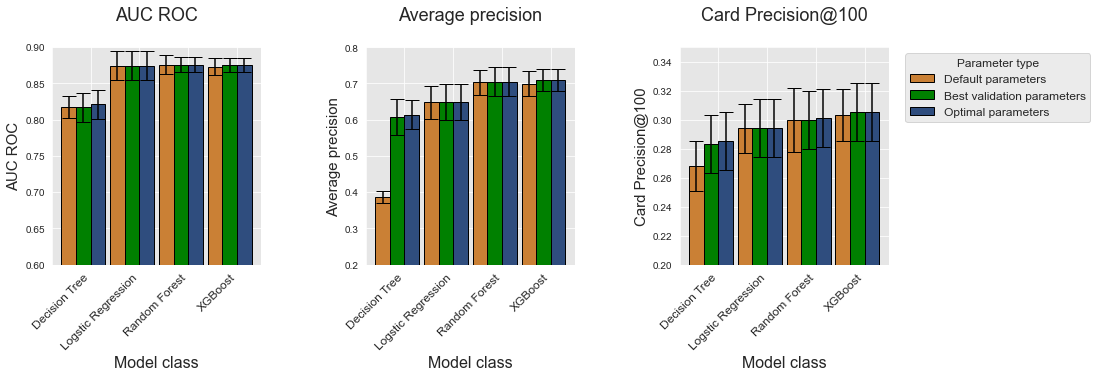

In [44]:
get_model_selection_performances_plots(performances_df_dictionary, 
                                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'])
    

In [45]:
#Let us plot the total execution times of the model selection procedure for each model class
execution_times=[execution_time_dt,execution_time_lr,
                 execution_time_rf,execution_time_boosting]

In [46]:
%%capture

fig_model_selection_execution_times_for_each_model_class, ax = plt.subplots(1, 1, figsize=(5,4))

model_classes=list(performances_df_dictionary.keys())
    
# width of the bars
barWidth = 0.3
# The x position of bars
r1 = np.arange(len(model_classes))
    
# Create execution times bars
ax.bar(r1, execution_times, 
        width = barWidth, color = 'black', edgecolor = 'black', 
        capsize=7)

ax.set_xticks(r1+barWidth/2)
ax.set_xticklabels(model_classes, rotation = 45, ha="right", fontsize=12)
ax.set_title('Model selection execution times \n for different model classes', fontsize=18)
ax.set_xlabel("Model class", fontsize=16)
ax.set_ylabel("Execution times (s)", fontsize=15)

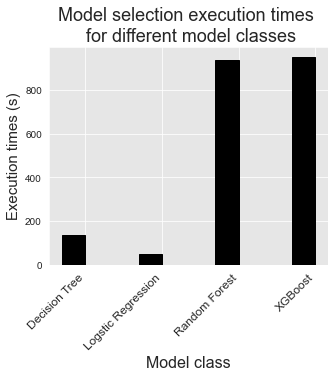

In [47]:
fig_model_selection_execution_times_for_each_model_class

In [48]:
#Random search

In [49]:
def prequential_parameters_search(transactions_df, 
                            classifier, 
                            input_features, output_feature, 
                            parameters, scoring, 
                            start_date_training, 
                            n_folds=4,
                            expe_type='Test',
                            delta_train=7, 
                            delta_delay=7, 
                            delta_assessment=7,
                            performance_metrics_list_grid=['roc_auc'],
                            performance_metrics_list=['AUC ROC'],
                            type_search='grid',
                            n_iter=10,
                            random_state=0,
                            n_jobs=-1):
    
    estimators = [('scaler', sklearn.preprocessing.StandardScaler()), ('clf', classifier)]
    pipe = sklearn.pipeline.Pipeline(estimators)
    
    prequential_split_indices=prequentialSplit(transactions_df,
                                               start_date_training=start_date_training, 
                                               n_folds=n_folds, 
                                               delta_train=delta_train, 
                                               delta_delay=delta_delay, 
                                               delta_assessment=delta_assessment)
    
    parameters_search = None
    
    if type_search=="grid":
        
        parameters_search = sklearn.model_selection.GridSearchCV(pipe, parameters, scoring=scoring, cv=prequential_split_indices, 
                                         refit=False, n_jobs=n_jobs)
    
    if type_search=="random":
        
        parameters_search = sklearn.model_selection.RandomizedSearchCV(pipe, parameters, scoring=scoring, cv=prequential_split_indices, 
                                     refit=False, n_jobs=n_jobs,n_iter=n_iter,random_state=random_state)

    
    X=transactions_df[input_features]
    y=transactions_df[output_feature]

    parameters_search.fit(X, y)
    
    performances_df=pd.DataFrame()
    
    for i in range(len(performance_metrics_list_grid)):
        performances_df[performance_metrics_list[i]+' '+expe_type]=parameters_search.cv_results_['mean_test_'+performance_metrics_list_grid[i]]
        performances_df[performance_metrics_list[i]+' '+expe_type+' Std']=parameters_search.cv_results_['std_test_'+performance_metrics_list_grid[i]]

    performances_df['Parameters']=parameters_search.cv_results_['params']
    performances_df['Execution time']=parameters_search.cv_results_['mean_fit_time']
    
    return performances_df

In [50]:
def model_selection_wrapper(transactions_df, 
                            classifier, 
                            input_features, output_feature,
                            parameters, 
                            scoring, 
                            start_date_training_for_valid,
                            start_date_training_for_test,
                            n_folds=4,
                            delta_train=7, 
                            delta_delay=7, 
                            delta_assessment=7,
                            performance_metrics_list_grid=['roc_auc'],
                            performance_metrics_list=['AUC ROC'],
                            type_search='grid',
                            n_iter=10,
                            random_state=0,
                            n_jobs=-1):

    # Get performances on the validation set using prequential validation
    performances_df_validation=prequential_parameters_search(transactions_df, classifier, 
                            input_features, output_feature,
                            parameters, scoring, 
                            start_date_training=start_date_training_for_valid,
                            n_folds=n_folds,
                            expe_type='Validation',
                            delta_train=delta_train, 
                            delta_delay=delta_delay, 
                            delta_assessment=delta_assessment,
                            performance_metrics_list_grid=performance_metrics_list_grid,
                            performance_metrics_list=performance_metrics_list,
                            type_search=type_search,
                            n_iter=n_iter,
                            random_state=random_state,
                            n_jobs=n_jobs)
    
    # Get performances on the test set using prequential validation
    performances_df_test=prequential_parameters_search(transactions_df, classifier, 
                            input_features, output_feature,
                            parameters, scoring, 
                            start_date_training=start_date_training_for_test,
                            n_folds=n_folds,
                            expe_type='Test',
                            delta_train=delta_train, 
                            delta_delay=delta_delay, 
                            delta_assessment=delta_assessment,
                            performance_metrics_list_grid=performance_metrics_list_grid,
                            performance_metrics_list=performance_metrics_list,
                            type_search=type_search,
                            n_iter=n_iter,
                            random_state=random_state,
                            n_jobs=n_jobs)
    
    # Bind the two resulting DataFrames
    performances_df_validation.drop(columns=['Parameters','Execution time'], inplace=True)
    performances_df=pd.concat([performances_df_test,performances_df_validation],axis=1)

    # And return as a single DataFrame
    return performances_df

In [51]:
#Let us rerun the model selection for boosting, but using random search, with 10 parameter combinations
classifier = xgboost.XGBClassifier()

parameters = {'clf__max_depth':[2,3,5], 'clf__n_estimators':[25,50,100],'clf__learning_rate':[0.05,0.1],
              'clf__random_state':[0],'clf__n_jobs':[1],'clf__n_verbosity':[0]}

start_time=time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        type_search='random',
                                        n_iter=10,
                                        random_state=0,
                                        n_jobs=1)

execution_time_boosting_random = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['clf__n_estimators'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__learning_rate'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__max_depth'])
                                   for i in range(len(parameters_dict))]

# Rename to performances_df_xgboost_random for model performance comparison
performances_df_xgboost_random=performances_df

In [52]:
performances_df_xgboost_random

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.833026,0.021529,0.638276,0.041124,0.292857,0.021093,"{'clf__random_state': 0, 'clf__n_verbosity': 0...",4.558726,0.824865,0.007403,0.620503,0.018740,0.285714,0.021213,50/0.05/2
1,0.838170,0.022672,0.644167,0.036922,0.292143,0.022734,"{'clf__random_state': 0, 'clf__n_verbosity': 0...",5.274810,0.825694,0.012097,0.629998,0.020038,0.284643,0.020785,25/0.05/5
2,0.867666,0.008072,0.698068,0.032792,0.302857,0.017642,"{'clf__random_state': 0, 'clf__n_verbosity': 0...",18.107155,0.872706,0.014283,0.674565,0.028685,0.290000,0.019614,100/0.05/5
3,0.849901,0.017226,0.656514,0.042243,0.293571,0.020714,"{'clf__random_state': 0, 'clf__n_verbosity': 0...",5.127610,0.847029,0.012538,0.641239,0.020743,0.284643,0.019016,50/0.1/2
4,0.874849,0.011891,0.709699,0.034596,0.304643,0.017594,"{'clf__random_state': 0, 'clf__n_verbosity': 0...",16.341235,0.886386,0.010339,0.691990,0.027580,0.294643,0.021603,100/0.1/3
5,0.836631,0.022184,0.646748,0.038027,0.293571,0.020813,"{'clf__random_state': 0, 'clf__n_verbosity': 0...",6.476840,0.832725,0.012021,0.634398,0.023909,0.288214,0.019362,50/0.05/3
6,0.850487,0.017482,0.658778,0.043274,0.292857,0.021993,"{'clf__random_state': 0, 'clf__n_verbosity': 0...",8.967643,0.845037,0.013504,0.641901,0.018981,0.285714,0.018378,100/0.05/2
7,0.870367,0.009253,0.697748,0.032718,0.302857,0.016660,"{'clf__random_state': 0, 'clf__n_verbosity': 0...",9.960756,0.873143,0.012046,0.676096,0.026784,0.289643,0.020137,50/0.1/5
8,0.874321,0.009236,0.707567,0.033676,0.302143,0.018253,"{'clf__random_state': 0, 'clf__n_verbosity': 0...",17.354602,0.878593,0.012366,0.691652,0.022994,0.289286,0.018253,100/0.1/5
9,0.833057,0.021551,0.638215,0.041323,0.292857,0.021452,"{'clf__random_state': 0, 'clf__n_verbosity': 0...",2.261190,0.824871,0.007406,0.620532,0.018880,0.286071,0.021102,25/0.1/2


In [53]:
summary_performances_xgboost_random=get_summary_performances(performances_df_xgboost_random, parameter_column_name="Parameters summary")
summary_performances_xgboost_random

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,100/0.1/3,100/0.1/3,100/0.1/3
Validation performance,0.886+/-0.01,0.692+/-0.03,0.295+/-0.02
Test performance,0.875+/-0.01,0.71+/-0.03,0.305+/-0.02
Optimal parameters,100/0.1/3,100/0.1/3,100/0.1/3
Optimal test performance,0.875+/-0.01,0.71+/-0.03,0.305+/-0.02


In [54]:
#The performances are essentially the same as those obtained with the grid search
# Performances with grid search
summary_performances_xgboost

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,100/0.1/3,100/0.1/3,100/0.1/3
Validation performance,0.886+/-0.01,0.692+/-0.03,0.295+/-0.02
Test performance,0.875+/-0.01,0.71+/-0.03,0.305+/-0.02
Optimal parameters,100/0.1/3,100/0.1/3,100/0.1/3
Optimal test performance,0.875+/-0.01,0.71+/-0.03,0.305+/-0.02


In [55]:
#The execution time was however significantly faster
print("Total execution time for XGBoost with grid search: "+str(round(execution_time_boosting,2))+"s")
print("Total execution time for XGBoost with random search: "+str(round(execution_time_boosting_random,2))+"s")

Total execution time for XGBoost with grid search: 949.51s
Total execution time for XGBoost with random search: 757.8s
